# Propensity Score

* Quando trabalhamos com observacionais, não randomizados, há questão no viés nos dados que não nos garante que tratados e não-tratados são comparáveis, essencialmente pelo impacto das variáveis confounders, que impactam tanto tratamento quanto a variável outcome

* Propensity Score determina a probabilidade, para cada observação ser designado para o tratamento, dado o conjunto de variáveis X (essencialmente confounders)

* O Propensity Score, P(x), nos permite controlar os confounders X, comparando observações tratadas e não-tratadas com score semelhantes, ou seja, que tem a mesma probabilidade de receber o tratamento

* A combinação direta das variáveis X, comparando observações parecidas, pode funcionar para poucas variáveis e amostras grandes, para mais variáveis e menos amostras, o controle pelo propensity score é apropriado, além de não se limitar ao pressuposto da linearidade via regressão, por exemplo, permitindo ajustes de interações mais complexas.

In [1]:
import pandas as pd
import numpy as np
from numpy import argmax
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings("ignore")

# Contexto do estudo

* Verificar o impacto do acesso a internet no domicilio do estudante na nota de redação do ENEM 2021
* Será utilizado a técnica de Propensity Score

#### Base ENEM 2021

In [2]:
enem = pd.read_csv('MICRODADOS_ENEM_2021.csv',encoding='latin-1', sep = ";")

In [3]:
enem.head()

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,210053865474,2021,5,F,1,1,1,1,3,1,...,A,A,A,B,A,A,B,A,B,B
1,210052384164,2021,12,M,1,1,1,1,11,1,...,A,A,A,B,A,A,C,A,A,A
2,210052589243,2021,13,F,3,1,1,1,15,1,...,B,A,A,B,A,A,C,B,B,B
3,210052128335,2021,3,M,1,3,1,2,0,2,...,A,A,A,B,A,A,B,A,B,B
4,210051353021,2021,2,F,1,3,1,2,0,2,...,B,A,A,B,A,B,E,A,B,B


In [4]:
len(enem)

3389832

# Escolha das variáveis
* Variável tratamento: Variável que se deseja mensurar o efeito/impacto
* Variável outcome (resultado/efeito): Variável que será influenciada pelo tratamento, em que será refletido o efeito
* Para demais variáveis, cabe o detalhamento:
    * Variáveis de confounders: É necessário, um requisito incluir as variáveis que causam (estão correlacionadas) tanto o outcome quanto o tratamento
    * Variáveis que reduzem a variância do outcome: É vantajoso a performance do modelo incluir variáveis que reduzem a variabilidade (são boas preditoras) da variável outcome, mesmo que não seja da variável tratamento
    * Variáveis nocivas ao modelo
        * Variáveis que sejam apenas boas preditoras do tratamento
        * Variáveis que estejam entre o tratamento e outcome, visualizado em um gráfico causal
        * Variáveis que são efeito comum entre o tratamento e outcome

# Variáveis da base

* Tratamento: Acesso a internet no domicilio
    * Q025 - Na sua residência possui acesso a internet?
        * A - Não
        * B - Sim
* Outcome: Nota de redação do enem
    * NU_NOTA_REDACAO
* Demais controles: Será analisado logo abaixo se cada uma destas variáveis sera inclusa no modelo
    * TP_ESCOLA: Tipo de escola do Ensino Médio
        * 1 - Nao respondeu
        * 2 - Pública
        * 3 - Privada
    * TP_LOCALIZACAO_ESC: Localização da escola
        * 1 - Urbana
        * 2 - Rural
    * Q006: Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares
        * A -	Nenhuma Renda
        * B -	Até R 1.100.00
        * C -  De R 1.100,01 até R 1.650,00.
        * D - 	De R 1.650,01 até R 2.200,00.
        * E - 	De R 2.200,01 até R 2.750,00.
        * F - 	De R 2.750,01 até R 3.300,00.
        * G - 	De R 3.300,01 até R 4.400,00.
        * H - 	De R 4.400,01 até R 5.500,00.
        * I - 	De R 5.500,01 até R 6.600,00.
        * J - 	De R 6.600,01 até R 7.700,00.
        * K - 	De R 7.700,01 até R 8.800,00.
        * L - 	De R 8.800,01 até R 9.900,00.
        * M - 	De R 9.900,01 até R 11.000,00.
        * N - 	De R 11.000,01 até R 13.200,00.
        * O - 	De R 13.200,01 até R 16.500,00.
        * P - 	De R 16.500,01 até R 22.000,00.
        * Q - 	Acima de R 22.000,00.
    * Q024: Na sua residência tem computador?
        * A -	Não.
        * B -	Sim, um.
        * C - 	Sim, dois.
        * D - 	Sim, três.
        * E -	Sim, quatro ou mais.

In [5]:
df = enem[['TP_ESCOLA','TP_LOCALIZACAO_ESC','Q006','Q024','Q025','NU_NOTA_REDACAO']]

In [6]:
df.head()

,TP_ESCOLA,TP_LOCALIZACAO_ESC,Q006,Q024,Q025,NU_NOTA_REDACAO
0,1,NaN,D,B,B,760.0
1,1,NaN,B,A,A,560.0
2,1,NaN,C,B,B,NaN
3,2,1.0,B,B,B,780.0
4,2,1.0,C,B,B,780.0


In [7]:
#verificando nulos
(df.isnull().sum()/len(df))*100

TP_ESCOLA              0.000000
TP_LOCALIZACAO_ESC    75.992734
Q006                   0.000059
Q024                   0.000059
Q025                   0.000059
NU_NOTA_REDACAO       29.837850
dtype: float64

* Como há muitos nulos na variável de localização da escola, decide-se incluir uma terceira classe, equivalente a informação não fornecida

In [8]:
df.fillna({'TP_LOCALIZACAO_ESC':3}, inplace=True)

In [9]:
# Retirando as linhas sem nota de redação
df.dropna(inplace=True)

In [10]:
# Restam cerca de 2,3 MM de provas
len(df)

2378378

* Um modelo simples, que seria verificar a média da nota entre os possíveis valores do tratamento, gera o resultado de que: O acesso a internet impacta positivamente a nota da prova em 93 pontos
    * Esse modelo será criticado com o Propensity Score, retirando o viés de outras variáveis que impactam o outcome

In [11]:
df.groupby('Q025')['NU_NOTA_REDACAO'].mean()

Q025
A    528.206907
B    621.557337
Name: NU_NOTA_REDACAO, dtype: float64

In [12]:
621-528

93

## Tipo de escola

#### VS Variável Tratamento 

* Visão gráfica
    * A principio, o acesso a internet é maior nas escolas privadas, na sequência, das não identificadas e púbica tem um % maior de não acesso a internet

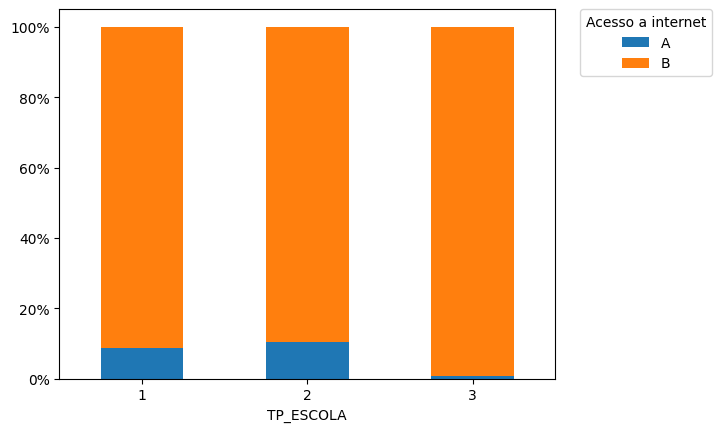

In [13]:
freq = pd.crosstab(df['TP_ESCOLA'], df['Q025'], normalize = 'index')*100
freq
ax = freq.plot.bar(stacked=True, rot=0)
plt.legend(title = "Acesso a internet", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

* Teste de hipotese - qui-quadrado
    * Como p-valor <0.05, há evidências para rejeitar a hipotese de nula que não ha relação entre as variaveis

In [14]:
from scipy.stats import chi2_contingency
df2 = pd.crosstab(df['TP_ESCOLA'], df['Q025'])
chi2, p, dof, ex = chi2_contingency(df2)
print(p)

0.0


    * V-cramer: Mensura a força entre a associação entre variáveis categoricas
        * O valor de 0.08 evidencia que, apesar de haver alguma relação, conforme teste acima, essa associação é fraca

In [15]:
df['cont'] = 1

In [16]:
chi = df.pivot_table('cont',df['TP_ESCOLA'], df['Q025'],aggfunc = 'count')
chi=chi.replace(np.nan,0)
xsq,pvalue,dof,expected=chi2_contingency(chi)
a = min(len(df['TP_ESCOLA'].unique()),len(df['Q025'].unique()))
b = len(df['TP_ESCOLA'])
vcramer = (xsq/(b*(a-1)))**(1/2)
print(vcramer)

0.08608020924817718


#### VS Variável Outcome 

* Visão gráfica
    * As notas de redação são maiores nas escolas privadas, na sequência vem as não identificadas e, por fim, as públicas

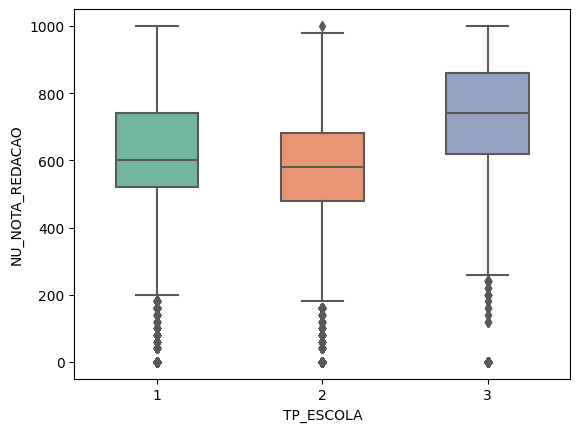

In [17]:
sns.boxplot(x="TP_ESCOLA", y="NU_NOTA_REDACAO", data=df, palette="Set2", width=0.5)
plt.show()

* Regressão Linear
    * Pelos coeficientes da regressão podemos atestar o impacto positivo de 115 pontos da escola privada na nota e redução de 45 para o colégio publico, ambos referenciados nas escola sem identificação

In [18]:
import statsmodels.api as sm
df_tip = df[['TP_ESCOLA','NU_NOTA_REDACAO']]
df_tip = pd.get_dummies(df_tip,columns=['TP_ESCOLA'], drop_first=True)
df_tip = sm.add_constant(df_tip)
Y = "NU_NOTA_REDACAO"
X = df_tip.columns.drop([Y])

In [19]:
model1 = sm.OLS(df_tip[Y], df_tip[X]).fit()

In [20]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                 5.299e+04
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        14:38:04   Log-Likelihood:            -1.5811e+07
No. Observations:             2378378   AIC:                         3.162e+07
Df Residuals:                 2378375   BIC:                         3.162e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         618.5040      0.153   4040.187      0.000     618.204     618.804
TP_ESCOLA_2   -45.5458      0.269   -169.144      0.000     -46.074     -45.018
TP_ESCOLA_3   111.5557      0.462    241.330      0.000     110.650     112.462
==============================================================================
Omnibus:                   341572.839   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           709071.416
Skew:                          -0.879   Prob(JB):                         0.00
Kurtosis:                       5.016   Cond. No.                         4.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Localização da escola

##### VS Variável Tratamento

* Visão gráfica
    * As escolas rurais possuem visivelmente uma taxa menor de acesso a internet quando comparado aos colégios urbanos e sem identificação

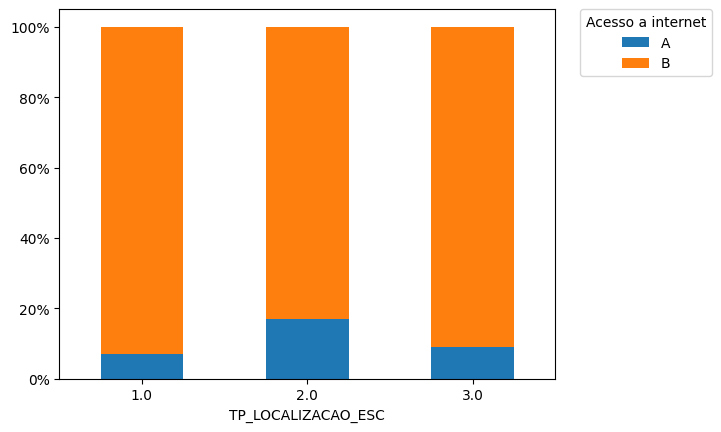

In [21]:
freq = pd.crosstab(df['TP_LOCALIZACAO_ESC'], df['Q025'], normalize = 'index')*100
freq
ax = freq.plot.bar(stacked=True, rot=0)
plt.legend(title = "Acesso a internet", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

* Teste de hipotese - qui-quadrado
    * Como p-valor <0.05, há evidências para rejeitar a hipotese de nula que não ha relação entre as variaveis

In [22]:
from scipy.stats import chi2_contingency
df2 = pd.crosstab(df['TP_LOCALIZACAO_ESC'], df['Q025'])
chi2, p, dof, ex = chi2_contingency(df2)
print(p)

0.0


       * V-cramer: Mensura a força entre a associação entre variáveis categoricas
           * Novamente, com um v-cramer baixo, a relação existente entre as variáveis é fraca

In [23]:
chi = df.pivot_table('cont',df['TP_LOCALIZACAO_ESC'], df['Q025'],aggfunc = 'count')
chi=chi.replace(np.nan,0)
xsq,pvalue,dof,expected=chi2_contingency(chi)
a = min(len(df['TP_LOCALIZACAO_ESC'].unique()),len(df['Q025'].unique()))
b = len(df['TP_LOCALIZACAO_ESC'])
vcramer = (xsq/(b*(a-1)))**(1/2)
print(vcramer)

0.042426405186051314


#### VS Variável Outcome 

* Visão gráfica
    * As escolas urbanas e não identificadas estão situadas acima das rurais na mediana e principalmente no terceiro quartil quanto as notas de redação

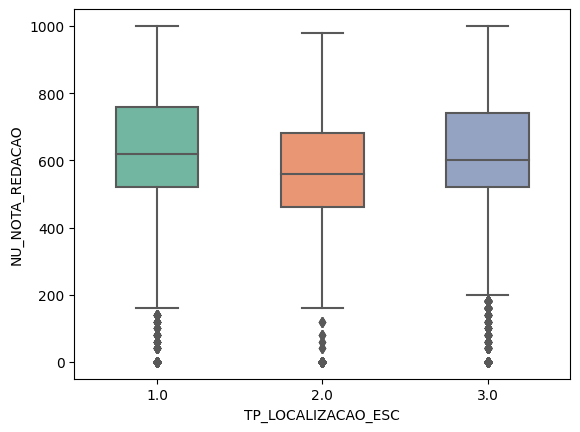

In [24]:
sns.boxplot(x="TP_LOCALIZACAO_ESC", y="NU_NOTA_REDACAO", data=df, palette="Set2", width=0.5)
plt.show()

* Regressão Linear
    * Com a escola urbana como referencial, a regressão evidencia que tanto a rural quanto as não identificadas tem uma queda da nota, dado os coeficientes significativos

In [25]:
import statsmodels.api as sm

In [26]:
df_loc = df[['TP_LOCALIZACAO_ESC','NU_NOTA_REDACAO']]
df_loc = pd.get_dummies(df_loc,columns=['TP_LOCALIZACAO_ESC'], drop_first=True)
df_loc = sm.add_constant(df_loc)
Y = "NU_NOTA_REDACAO"
X = df_loc.columns.drop([Y])

In [27]:
model2 = sm.OLS(df_loc[Y], df_loc[X]).fit()

In [28]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1247.
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        14:38:06   Log-Likelihood:            -1.5862e+07
No. Observations:             2378378   AIC:                         3.172e+07
Df Residuals:                 2378375   BIC:                         3.172e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    619.2375      0.243   2544.428      0.000     618.760     619.714
TP_LOCALIZACAO_ESC_2.0   -64.5278      1.389    -46.473      0.000     -67.249     -61.806
TP_LOCALIZACAO_ESC_3.0    -7.0983      0.283    -25.089      0.000      -7.653      -6.544
==============================================================================
Omnibus:                   327127.831   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           650787.091
Skew:                          -0.862   Prob(JB):                         0.00
Kurtosis:                       4.896   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Renda mensal familiar 

#### VS Variável Tratamento 

* Visão gráfica
    * É notavel o aumento do acesso a internet conforme o aumento da renda, principalmente das classes C e D em diante (R 1.6/2 mil em diante)

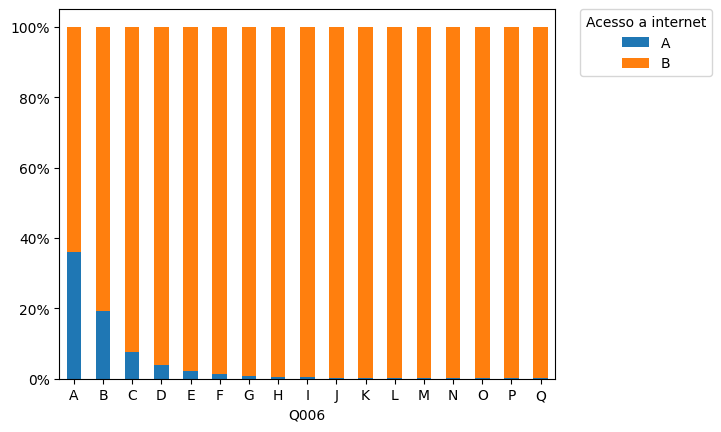

In [29]:
freq = pd.crosstab(df['Q006'], df['Q025'], normalize = 'index')*100
freq
ax = freq.plot.bar(stacked=True, rot=0)
plt.legend(title = "Acesso a internet", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

* Teste de hipotese - qui-quadrado
    * Como p-valor <0.05, há evidências para rejeitar a hipotese de nula que não ha relação entre as variaveis

In [30]:
from scipy.stats import chi2_contingency
df2 = pd.crosstab(df['Q006'], df['Q025'])
chi2, p, dof, ex = chi2_contingency(df2)
print(p)

0.0


    * V-cramer: Mensura a força entre a associação entre variáveis categoricas
        * Com a variável de renda há um v-cramer maior, assim, existe uma associação moderada entre as variáveis

In [31]:
chi = df.pivot_table('cont',df['Q006'], df['Q025'],aggfunc = 'count')
chi=chi.replace(np.nan,0)
xsq,pvalue,dof,expected=chi2_contingency(chi)
a = min(len(df['Q006'].unique()),len(df['Q025'].unique()))
b = len(df['Q006'])
vcramer = (xsq/(b*(a-1)))**(1/2)
print(vcramer)

0.347179475773926


##### VS Variável Outcome

* Visão gráfica
    * A nota de redação cresce gradativamente conforme a renda aumenta, até estabilizar por volta da classe K (R 7 - 8 mil)

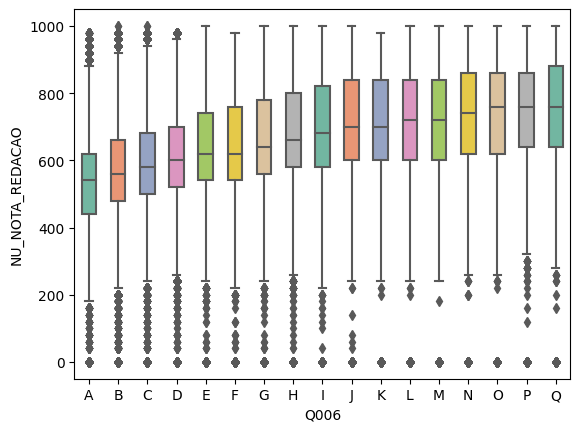

In [32]:
sns.boxplot(x="Q006", y="NU_NOTA_REDACAO", data=df, palette="Set2", width=0.5,
           order = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q'])
plt.show()

* Regressao Linear
    * Com a variavel renda como dummy, utilizando a menor classe de renda como referência, todos os coeficientes são significativos, e gradativamente maiores

In [33]:
df_rend = df[['Q006','NU_NOTA_REDACAO']]
df_rend = pd.get_dummies(df_rend,columns=['Q006'], drop_first=True)
df_rend = sm.add_constant(df_rend)
Y = "NU_NOTA_REDACAO"
X = df_rend.columns.drop([Y])

In [34]:
model3 = sm.OLS(df_rend[Y], df_rend[X]).fit()

In [35]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                 1.501e+04
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        14:38:12   Log-Likelihood:            -1.5749e+07
No. Observations:             2378378   AIC:                         3.150e+07
Df Residuals:                 2378361   BIC:                         3.150e+07
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        524.9004      0.520   1009.421      0.000     523.881     525.920
Q006_B        31.7432      0.571     55.554      0.000      30.623      32.863
Q006_C        61.8491      0.599    103.202      0.000      60.674      63.024
Q006_D        77.9640      0.618    126.138      0.000      76.753      79.175
Q006_E        96.1438      0.698    137.726      0.000      94.776      97.512
Q006_F       111.2419      0.676    164.521      0.000     109.917     112.567
Q006_G       129.3330      0.696    185.882      0.000     127.969     130.697
Q006_H       147.1123      0.733    200.766      0.000     145.676     148.548
Q006_I       160.9203      0.831    193.620      0.000     159.291     162.549
Q006_J       170.7520      0.973    175.472      0.000     168.845     172.659
Q006_K       177.5884      1.061    167.360      0.000     175.509     179.668
Q006_L       181.7226      1.116    162.870      0.000     179.536     183.909
Q006_M       189.4899      0.966    196.139      0.000     187.596     191.383
Q006_N       200.0611      1.153    173.551      0.000     197.802     202.320
Q006_O       207.6455      1.112    186.720      0.000     205.466     209.825
Q006_P       214.2053      1.112    192.638      0.000     212.026     216.385
Q006_Q       220.5969      1.028    214.678      0.000     218.583     222.611
==============================================================================
Omnibus:                   383612.790   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           871778.287
Skew:                          -0.940   Prob(JB):                         0.00
Kurtosis:                       5.294   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Computador na residência

#### VS Variável Tratamento 

* Visão gráfica
    * Quando não ha computador na residência, ha uma taxa alta de ausência de acesso a internet, por fim, com algum computador na casa, a taxa de não acesso a rede cai vertiginosamente

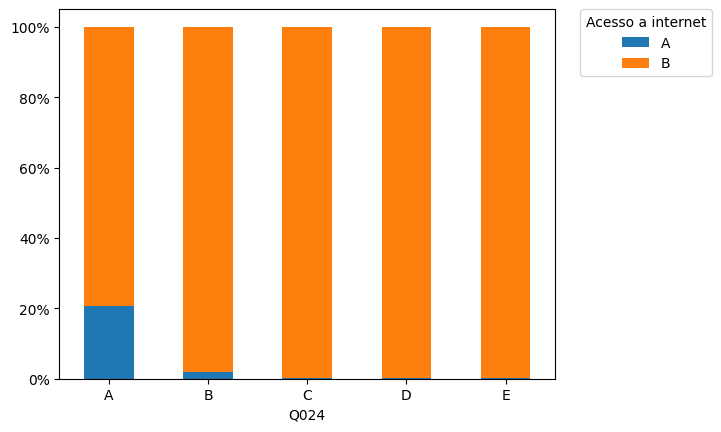

In [36]:
freq = pd.crosstab(df['Q024'], df['Q025'], normalize = 'index')*100
freq
ax = freq.plot.bar(stacked=True, rot=0)
plt.legend(title = "Acesso a internet", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

* Teste de hipotese - qui-quadrado
    * Como p-valor <0.05, há evidências para rejeitar a hipotese de nula que não ha relação entre as variaveis

In [37]:
from scipy.stats import chi2_contingency
df2 = pd.crosstab(df['Q024'], df['Q025'])
chi2, p, dof, ex = chi2_contingency(df2)
print(p)

0.0


    * V-cramer: Mensura a força entre a associação entre variáveis categoricas
        * Semelhante a associação com renda, temos um v-cramer moderado em relação ao acesso a computadores

In [38]:
chi = df.pivot_table('cont',df['Q024'], df['Q025'],aggfunc = 'count')
chi=chi.replace(np.nan,0)
xsq,pvalue,dof,expected=chi2_contingency(chi)
a = min(len(df['Q024'].unique()),len(df['Q025'].unique()))
b = len(df['Q024'])
vcramer = (xsq/(b*(a-1)))**(1/2)
print(vcramer)

0.33466699535586214


#### VS Variável Outcome 

* Visão gráfica
    * Há a tendencia de elevação da nota conforme há mais computadores na residencia do aluno, principalmente até 03

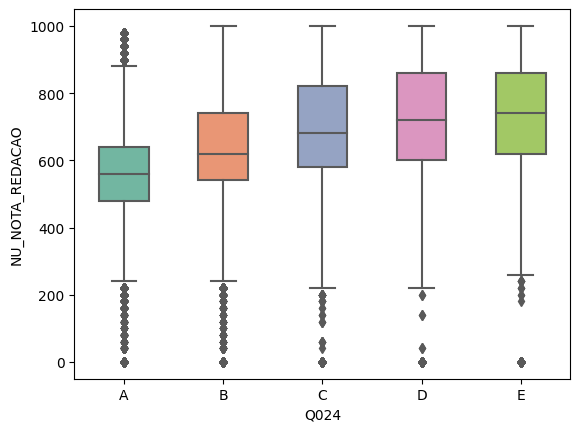

In [39]:
sns.boxplot(x="Q024", y="NU_NOTA_REDACAO", data=df, palette="Set2", width=0.5,
           order = ['A','B','C','D','E'])
plt.show()

* Regressão Linear
    * Os coeficientes da regressão confirmam a tendência acima, todos estatisticamente significantes e positivamente correlacionados com a nota

In [40]:
df_comp = df[['Q024','NU_NOTA_REDACAO']]
df_comp = pd.get_dummies(df_comp,columns=['Q024'], drop_first=True)
df_comp = sm.add_constant(df_comp)
Y = "NU_NOTA_REDACAO"
X = df_comp.columns.drop([Y])

In [41]:
model4 = sm.WLS(df_comp[Y], df_comp[X]).fit()

In [42]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                 5.328e+04
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        14:38:15   Log-Likelihood:            -1.5761e+07
No. Observations:             2378378   AIC:                         3.152e+07
Df Residuals:                 2378373   BIC:                         3.152e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        552.8622      0.193   2870.899      0.000     552.485     553.240
Q024_B        74.6872      0.265    281.888      0.000      74.168      75.207
Q024_C       133.8285      0.389    343.781      0.000     133.065     134.591
Q024_D       163.0394      0.567    287.762      0.000     161.929     164.150
Q024_E       175.8925      0.764    230.179      0.000     174.395     177.390
==============================================================================
Omnibus:                   377742.351   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           839571.426
Skew:                          -0.935   Prob(JB):                         0.00
Kurtosis:                       5.231   Cond. No.                         7.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Associação entre as variáveis explicativas

* Como todas as variaveis estão categóricas, utiliza-se o V-cramer para estabelecer estas associaçoes:

In [43]:
df['TP_ESCOLA'] = df['TP_ESCOLA'].astype('str')
df['TP_LOCALIZACAO_ESC'] = df['TP_LOCALIZACAO_ESC'].astype('str')
df['cont'] = 1

In [44]:
df_cat = df[['TP_ESCOLA','TP_LOCALIZACAO_ESC','Q006','Q024','cont']]

* O tipo de escola e sua localização são as variáveis mais fortemente associadas (ainda que o efeito seja moderado)
* Em sequência, renda e acesso a computador possuem um grau razoavel de força de associação
* Por fim, o tipo da escola possue grau médio de associacao tanto com renda quanto acesso a computador

In [45]:
from scipy.stats import chi2_contingency
categoricas = df_cat.select_dtypes(include=['object']).columns.tolist() #cria uma lista das variaveis categoricas
chimap = pd.DataFrame(columns=['Var1','Var2','xsq','pvalue','vcramer']) #cria dataframe para inserir valores do chisquare
for x in categoricas:
    for y in categoricas:
        if x != y:
            chi = df_cat.pivot_table('cont',index= [x],columns= [y] ,aggfunc = 'count')
            chi=chi.replace(np.nan,0)
            xsq,pvalue,dof,expected=chi2_contingency(chi)
            a = min(len(df_cat[x].unique()),len(df_cat[y].unique()))
            b = len(df_cat[x])
            vcramer = (xsq/(b*(a-1)))**(1/2)
            chimap = chimap.append({'Var1' : x, 'Var2' : y, 'xsq': xsq, 'pvalue': pvalue, 'vcramer':vcramer}, ignore_index=True)
chimap = chimap.sort_values(by = 'vcramer', ascending = False)
chimap

,Var1,Var2,xsq,pvalue,vcramer
0,TP_ESCOLA,TP_LOCALIZACAO_ESC,1.486386e+06,0.0,0.558998
3,TP_LOCALIZACAO_ESC,TP_ESCOLA,1.486386e+06,0.0,0.558998
11,Q024,Q006,1.424168e+06,0.0,0.386910
8,Q006,Q024,1.424168e+06,0.0,0.386910
1,TP_ESCOLA,Q006,2.781146e+05,0.0,0.241800
6,Q006,TP_ESCOLA,2.781146e+05,0.0,0.241800
2,TP_ESCOLA,Q024,2.017974e+05,0.0,0.205969
9,Q024,TP_ESCOLA,2.017974e+05,0.0,0.205969
4,TP_LOCALIZACAO_ESC,Q006,2.629349e+04,0.0,0.074348
7,Q006,TP_LOCALIZACAO_ESC,2.629349e+04,0.0,0.074348


## Grafico causal 

* Conclui-se a partir da relação das variáveis estudadas acima
    * Todas as variáveis explicativas estão relacionadas/explicam a variabilidade do tratamento e do outcome, então, a principio, poderiam fazer parte do modelo
    * Porém, ha assoacicoes significativas entre estas variáveis, de tal forma que:
        * Renda esta associado com o tipo de escola e acesso a computador, o que faz sentido que a primeira cause as duas outras
        * A localização da escola, apesar de estar associado com o tipo da escola, não esta muito com renda, sendo assim, na ausência da segunda, faz sentido que esteja no modelo
    * Desta forma, as variáveis inclusas junto com o tratamento e o outcome serão renda e localizacao da escola

In [1]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
import hyper

In [2]:
from causalgraphicalmodels import CausalGraphicalModel
import graphviz

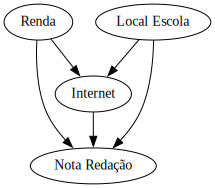

In [3]:
sprinkler = CausalGraphicalModel(
    nodes=["Nota Redação", "Internet", "Renda","Local Escola"],
    edges=[
        ("Renda", "Internet"), 
        ("Local Escola", "Internet"),
        ("Internet", "Nota Redação"),
        ("Renda","Nota Redação"),
        ("Local Escola","Nota Redação")
    ]
)

sprinkler.draw()

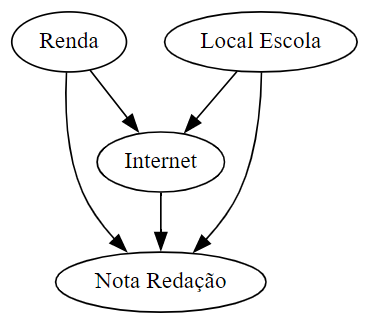

## Calculo do Propensity Score

* Será utilizado a regressão logística como função geradora do score

In [52]:
# Separando a base
df2 = df[['Q025','Q006','TP_LOCALIZACAO_ESC','NU_NOTA_REDACAO']]

In [53]:
# Transformando a variavel de intervenção em dummy
df2['intervencao'] = np.where(df2['Q025'] == 'A', 0, 1)

In [54]:
# Tratando variaveis categoricas
df2 = pd.get_dummies(df2,columns=['Q006'], drop_first = True)
df2 = pd.get_dummies(df2,columns=['TP_LOCALIZACAO_ESC'], drop_first = True)

In [55]:
df2.head()

,Q025,NU_NOTA_REDACAO,intervencao,Q006_B,Q006_C,Q006_D,Q006_E,Q006_F,Q006_G,Q006_H,...,Q006_J,Q006_K,Q006_L,Q006_M,Q006_N,Q006_O,Q006_P,Q006_Q,TP_LOCALIZACAO_ESC_2.0,TP_LOCALIZACAO_ESC_3.0
0,B,760.0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,A,560.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,B,780.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B,780.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,B,480.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [82]:
from sklearn.linear_model import LogisticRegression
T = 'intervencao'
Y = 'NU_NOTA_REDACAO'
X = df2.columns.drop(['Q025',T, Y])

ps_model = LogisticRegression(C=1e6).fit(df2[X], df2[T])

data_ps = df2.assign(propensity_score=ps_model.predict_proba(df2[X])[:, 1])

In [83]:
data_ps.head()

,Q025,NU_NOTA_REDACAO,intervencao,Q006_B,Q006_C,Q006_D,Q006_E,Q006_F,Q006_G,Q006_H,...,Q006_K,Q006_L,Q006_M,Q006_N,Q006_O,Q006_P,Q006_Q,TP_LOCALIZACAO_ESC_2.0,TP_LOCALIZACAO_ESC_3.0,propensity_score
0,B,760.0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.960370
1,A,560.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.806096
3,B,780.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.817765
4,B,780.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.928044
6,B,480.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.922770


In [84]:
data_ps = pd.concat([data_ps, df[['Q006']]], join='inner', axis=1)
data_ps = pd.concat([data_ps, df[['TP_LOCALIZACAO_ESC']]], join='inner', axis=1)

* Plotar o score de propensão pelas variáveis explicativas nos auxilia a verificar que existe um viés na atribuição do tratamento, ou seja, que tratados e não-tratados não seriam comparaveis
    * Em renda, os scores das rendas mais baixas são bem distintos, até que se estabilizam próximo a faixa F/G 
    * Para localização da escola, o score é semelhante para escolas urbanas e sem descrição, acima das escolas rurais

<AxesSubplot: xlabel='Q006', ylabel='propensity_score'>

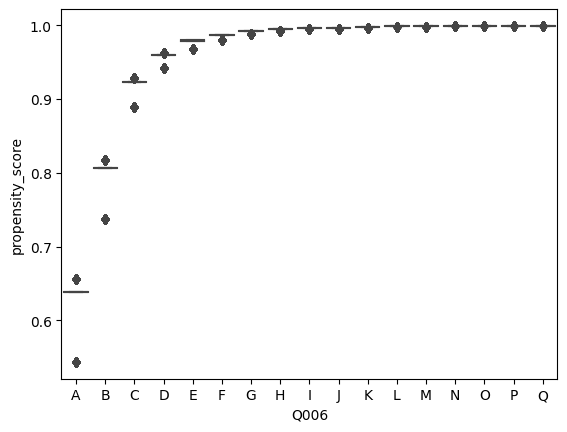

In [85]:
sns.boxplot(x="Q006", y="propensity_score", data=data_ps, 
            order = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q'])

<AxesSubplot: xlabel='TP_LOCALIZACAO_ESC', ylabel='propensity_score'>

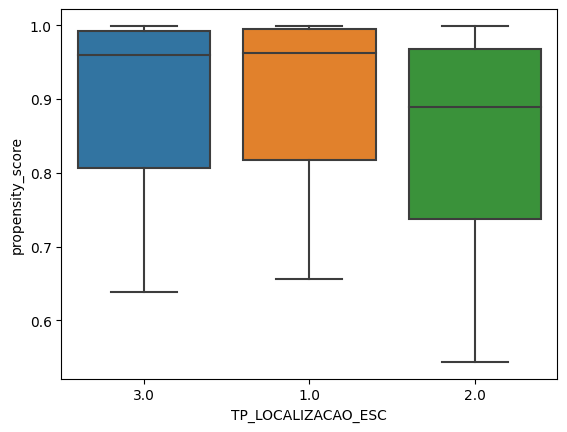

In [86]:
sns.boxplot(x="TP_LOCALIZACAO_ESC", y="propensity_score", data=data_ps)

* É essencial a aplicação do método existir um equilibrio no score entre tratados e não-tratados, ou seja, que exista sobreposição nas diversas faixas do score entre os 02 grupos
    * Conforme disposto abaixo, no caso do acesso a internet (o tratamento), **não** há esta sobreposição, dado que para os maiores scores (de maior renda e escolas urbanas) quase não alunos sem acesso a internet
    * Assim, para seguir com o estudo, será escolhido um range do score em que há amostras de tratados e não-tratados (menor que 0.9
        * Obviamente, esta escolha pode atribuir um vies ao resultado, dado que estamos excluindo um público que dificilmente poderemos extrapolar o resultado

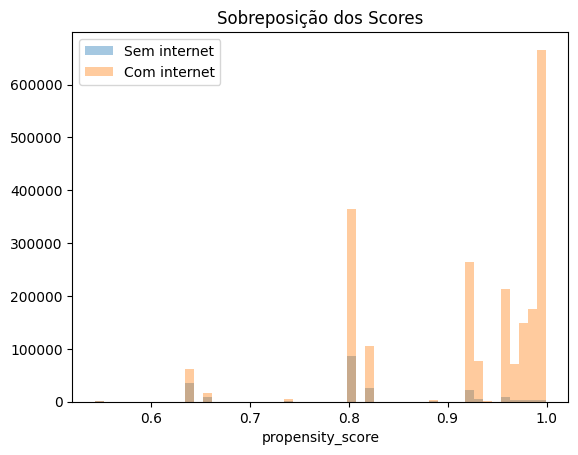

In [87]:
sns.distplot(data_ps.query("intervencao==0")["propensity_score"], kde=False, label="Sem internet")
sns.distplot(data_ps.query("intervencao==1")["propensity_score"], kde=False, label="Com internet")
plt.title("Sobreposição dos Scores")
plt.legend()

## IPTW e Intervalo de confiança

* Dado os scores e o intervalo destes definido para a estimativa do impacto, aplica-se o IPTW (Inverse probability weighting)
    * Método estatistico para remover o efeito das variáveis confounders
    * Cada amostra terá um peso no calculo da média do efeito, e esse peso é definido pelo inverso da probabilidade daquela amostra pertencer ao respectivo grupo, sendo, para o tratamento : (1/score) e para não-trarados (1/(1-score))
    * Por essa metodologia, garante-se peso maior as amostras que tem menor probabilidade de pertencer aos tratados e não-tratados
        * Ou seja, se temos um tratado com score baixo, implica que ele tem características de um não-tratado, o que é uma ótima observação para se comparar com os não-tratados de fato
    * Multiplica-se a qtdd de amostras de um dado score pelo seu respectivo peso, criando uma pseudopopulação para tratados e não-tratados, ambas de mesmo tamanho
    * Por fim, extra-se a média destas pseudopopulações entre tratados e não-tratados

In [88]:
data_ps2 = data_ps[data_ps['propensity_score']< 0.9] #pegando scores menores que 0.9: região com algum grau de sobreposição

weight_t = 1/data_ps2.query("intervencao==1")["propensity_score"] #calculando peso para cada tratado
weight_nt = 1/(1-data_ps2.query("intervencao==0")["propensity_score"]) #calculando peso para cada não-tratado


y1 = sum(data_ps2.query("intervencao==1")["NU_NOTA_REDACAO"]*weight_t) / len(data_ps2) #calculando média da nota entre tratados
y0 = sum(data_ps2.query("intervencao==0")["NU_NOTA_REDACAO"]*weight_nt) / len(data_ps2) #calculando médoa entre não-tratados


print("Y1:", y1)
print("Y0:", y0)
print("Efeito Médio", y1-y0) #capturando o efeito médio do tratamento

Y1: 559.0750408666033
Y0: 522.7927349803541
Efeito Médio 36.28230588624922


* Observa-se que o efeito calculado por este método é bem distinto da estimativa inicial, apenas comparando as médias de quem tem e não tem internet
* A magnitude do efeito é menor (36 contra 93), evidenciando que há viés na comparação inicial

* Como uma estimativa, é prudente fornecer um intervalo de confiança para o parâmetro
* Utiliza-se o metodo do bootstrapping para realizar o intervalo

In [89]:
def propens_score(base,X,T,Y): #funcao que calcula o efeito médio do acesso a internet
    modelo = LogisticRegression(C=1e6, solver = "saga").fit(base[X], base[T])
    base_ps = base.assign(propensity_score=modelo.predict_proba(base[X])[:, 1])
    base_ps2 = base_ps[base_ps['propensity_score']< 0.9]
    weight = ((base_ps2["intervencao"]-base_ps2["propensity_score"]) /
          (base_ps2["propensity_score"]*(1-base_ps2["propensity_score"])))
    ate = np.mean(weight * base_ps2["NU_NOTA_REDACAO"])
    return ate

* Realiza-se abaixo 5 reamostragens para fins de demonstração, porém, o ideal é realizar pelo menos 1.000

In [98]:
np.random.seed(100)
lista = []
for x in range(1,5):
    base = df2.sample(frac=1, replace=True)
    ates = propens_score(base,X,T,Y)
    lista.append(ates)

In [99]:
lista

[37.06846402281338, 37.06514414596164, 36.86063868479491, 35.722230246385706]

## Regressão com Propensity Score

* O score pode ser utilizado como uma variável em uma regressão com a função de controlar o viés

In [65]:
data_ps_reg = data_ps[['intervencao','NU_NOTA_REDACAO','propensity_score']]
data_ps_reg = sm.add_constant(data_ps_reg)
Y = "NU_NOTA_REDACAO"
X = data_ps_reg.columns.drop([Y])

In [66]:
model5 = sm.OLS(data_ps_reg[Y], data_ps_reg[X]).fit()

* O impacto do tratamento, neste modelo, é de 38.7 a 40.4, um pouco acima do que o estimado anteriormente

In [67]:
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        NU_NOTA_REDACAO   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                 8.195e+04
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:27:16   Log-Likelihood:            -1.5784e+07
No. Observations:             2378378   AIC:                         3.157e+07
Df Residuals:                 2378375   BIC:                         3.157e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              171.0265      1.126    151.955      0.000     168.821     173.232
intervencao         39.5939      0.454     87.159      0.000      38.704      40.484
propensity_score   444.6717      1.306    340.402      0.000     442.111     447.232
==============================================================================
Omnibus:                   360019.116   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           770074.473
Skew:                          -0.909   Prob(JB):                         0.00
Kurtosis:                       5.113   Cond. No.                         23.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""